# GPR Simulation Data

See what happens when we use simulation data rather than our simple Gaussian-shaped thermal.

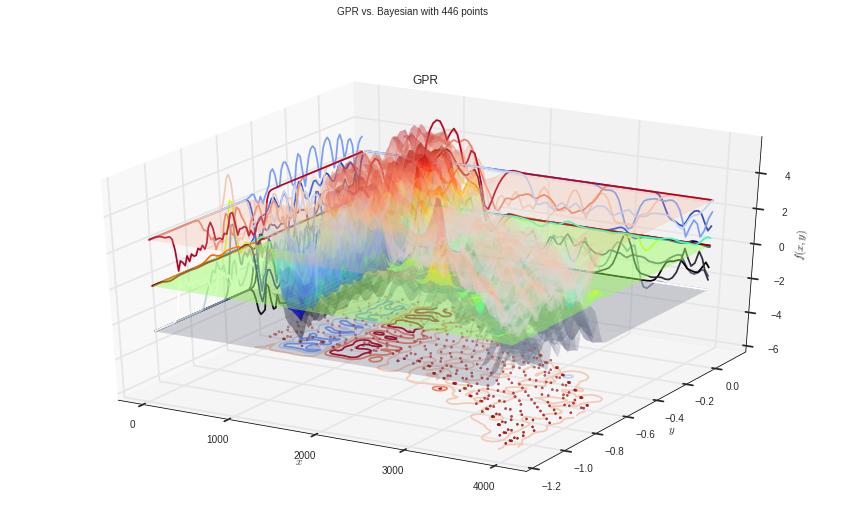

GPR Parameters: Theta0: 0.100000, ThetaL: 0.000000, ThetaU: 10000000000.000000, Nugget: 0.000000, RandomStart: 100
GPR Params:
  sigma^2: [ 1.70826798] beta: [[ 0.02070711]]
GPR theta value (theta of scikit-learn and DACE, l of R&W and Lawrance):
   [ 89.81599304] [ 0.07461191]


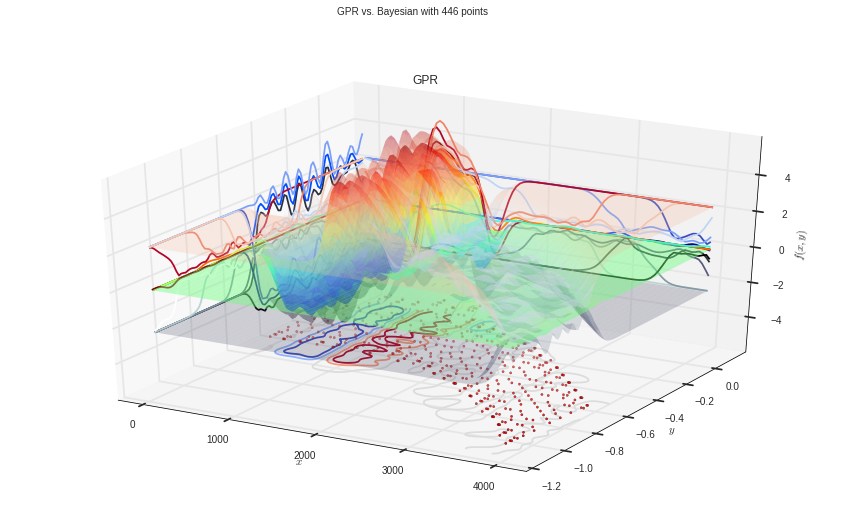

GPR Parameters: Theta0: 0.100000, ThetaL: 0.000000, ThetaU: 10000000000.000000, Nugget: 0.010000, RandomStart: 100
GPR Params:
  sigma^2: [ 1.41583948] beta: [[-0.006008]]
GPR theta value (theta of scikit-learn and DACE, l of R&W and Lawrance):
   [ 30.39826696] [ 0.12825095]


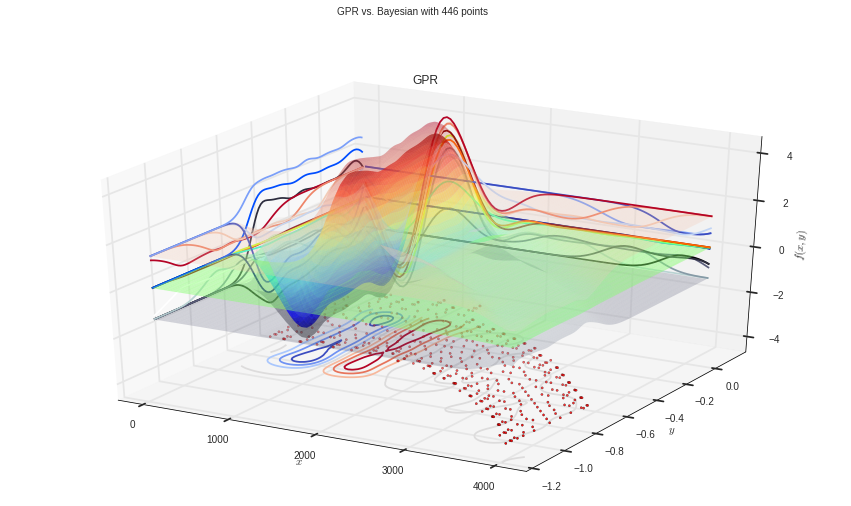

GPR Parameters: Theta0: 0.100000, ThetaL: 0.000000, ThetaU: 10000000000.000000, Nugget: 1.000000, RandomStart: 100
GPR Params:
  sigma^2: [ 0.45407738] beta: [[ 0.04562736]]
GPR theta value (theta of scikit-learn and DACE, l of R&W and Lawrance):
   [ 9.30136345] [ 0.23185245]


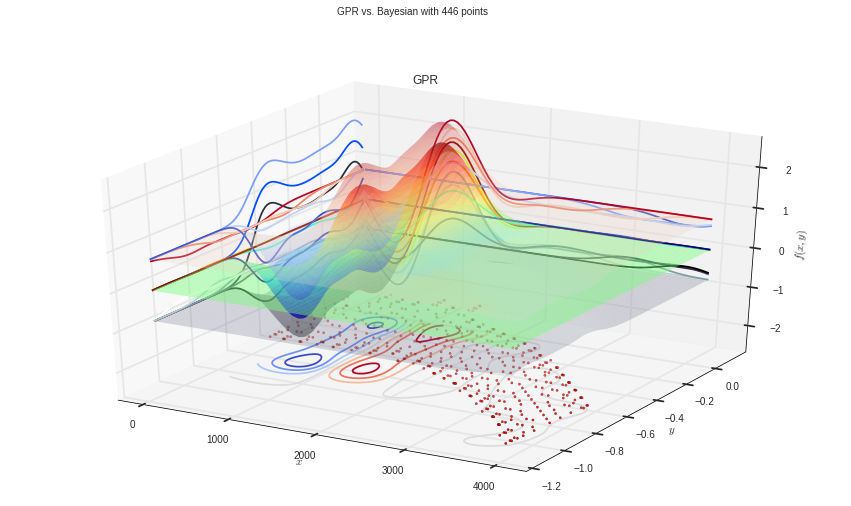

GPR Parameters: Theta0: 0.100000, ThetaL: 0.000000, ThetaU: 10000000000.000000, Nugget: 10.000000, RandomStart: 100
GPR Params:
  sigma^2: [ 0.1415144] beta: [[ 0.00526262]]
GPR theta value (theta of scikit-learn and DACE, l of R&W and Lawrance):
   [ 7.20207363] [ 0.2634852]


In [36]:
# For calculation
import sys
import random
import numpy as np
import pymc3 as pm
import scipy as sp
import theano
import theano.tensor as t
from scipy.stats import kde
from collections import Counter
from sklearn.gaussian_process import GaussianProcess

# For visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.path import Path
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
from pandas.tools.plotting import andrews_curves
import seaborn as sns
sns.set(style="ticks")

# Display plots in Jupyter
%matplotlib inline

# For reproducibility
random.seed(126)
np.random.seed(123)

# Vertical velocity as function of the thermal's position and width
def deterministicVelocity(path, measurements, thermal_position,
                          thermal_amplitude, thermal_sd):
    # Fix "Cannot compute test value" error, see: http://stackoverflow.com/a/30241668
    #theano.config.compute_test_value = 'ignore'
    
    # Create the function but already plug in some values we want to test with
    # See: https://www.quora.com/What-is-the-meaning-and-benefit-of-shared-variables-in-Theano
    x = theano.shared(np.array([x for x,y in path]))
    y = theano.shared(np.array([y for x,y in path]))
    
    # These functions now refer to the shared variables
    # Do not compile here, see: http://stackoverflow.com/q/30426216
    def gaussianTheano(xo, yo, amplitude, sigma_x, sigma_y):
        #xo = float(xo)
        #yo = float(yo)
        theta = offset = 0 # for now
        a = (pm.cos(theta)**2)/(2*sigma_x**2) + (pm.sin(theta)**2)/(2*sigma_y**2)
        b = -(pm.sin(2*theta))/(4*sigma_x**2) + (pm.sin(2*theta))/(4*sigma_y**2)
        c = (pm.sin(theta)**2)/(2*sigma_x**2) + (pm.cos(theta)**2)/(2*sigma_y**2)
        gauss = offset+amplitude*pm.exp(-1*(a*((x-xo)**2)+2*b*(x-xo)*(y-yo)+c*((y-yo)**2)))
        return gauss
    
    # Return the Theano function that we'll use when sampling
    return gaussianTheano(thermal_position[0], thermal_position[1],
                          thermal_amplitude, thermal_sd, thermal_sd)

# Zero offset, rotation, and same sigma in both x and y
def thermalEq(position, amplitude, sd):
    return gaussian(position[0], position[1], amplitude, sd, sd, 0, 0)

# See: http://stackoverflow.com/q/25342899
def gaussian(xo, yo, amplitude, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    gauss = lambda x,y: offset+amplitude*np.exp(-1*(a*((x-xo)**2)+2*b*(x-xo)*(y-yo)+c*((y-yo)**2)))
    return gauss

# Take single measurement
def takeMeasurement(field, position):
    measurement = 0

    for thermal in field:
        measurement += thermal(position[0], position[1])

    return measurement

# Take measurements at the points along the path
# Input: field=[eq1, eq2, ...], path=[(x1,y1),(x2,y2),...]
# Output: [v1, v2, ...]
def takeMeasurements(field, path):
    measurements = np.empty(len(path))
    
    for i, pos in enumerate(path):
        measurements[i] = takeMeasurement(field, pos)
    
    return measurements

# Take measurements from the simulation data
def takeMeasurementsData(data):
    return np.array(data[['VelDown']])

# Get the path from the simulation data
def getPathData(data):
    return np.array(data[['x', 'y']])

#
# Create the visualization of the 3D thermal field, our path,
# and where we think the thermals are
#
def visualizeThermalField(field, path, measurements, trace, pos_min, pos_max,
                          legend=False, only2d=False, center=None,
                          fig=None, subplot=111, lines=True,
                          limits=None):
    if not fig:
        fig = plt.figure(figsize=(15,8))
    
    if only2d:
        ax = fig.add_subplot(subplot)
    else:
        ax = fig.add_subplot(subplot, projection='3d')
    
    plt.title('Bayesian')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    
    if not only2d:
        ax.set_zlabel('$f(x,y)$')
    
    # The learned values, first so they're displayed on the bottom
    plt.scatter(trace["thermal_position"][:,0], trace["thermal_position"][:,1],
                alpha=0.05, c="r")
    
    # Evaluate thermal field equations over X,Y
    # See: http://matplotlib.org/examples/mplot3d/surface3d_demo.html
    X = np.arange(pos_min, pos_max, (pos_max-pos_min)/40)
    Y = np.arange(pos_min, pos_max, (pos_max-pos_min)/40)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros((len(X),len(Y)))

    for thermal in field:
        Z += thermal(X, Y)

    if not only2d:
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                           alpha=0.5, linewidth=0, antialiased=True)

        #fig.colorbar(surf, aspect=10, shrink=0.3)

    # Contours so we can see how it compares with the path
    # See: http://matplotlib.org/examples/mplot3d/contour3d_demo3.html
    cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='x', offset=pos_min, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='y', offset=pos_max, cmap=cm.coolwarm)
    
    # Plot the path
    # See: http://matplotlib.org/examples/mplot3d/lines3d_demo.html
    #ax.plot(X, Y, Z)
    
    # Plot the path as line segments
    # See: http://stackoverflow.com/a/11541628
    if lines:
        for i in range(1, len(path)):
            if only2d:
                ax.plot([path[i-1][0], path[i][0]], [path[i-1][1],path[i][1]],
                    label='Path Segment #'+str(i))
            else:
                ax.plot([path[i-1][0], path[i][0]], [path[i-1][1],path[i][1]],
                        zs=[0,0], label='Path Segment #'+str(i))
    
    # Otherwise, just plot the observed points
    #else:
    #    ax.scatter(path[:,0], path[:,1], measurements,
    #                c='r', marker='.', s=20, label='Observed')
    
    # Put legend outside the graph
    # See: http://stackoverflow.com/a/4701285
    if legend:
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Display where we think the center is
    if center:
        ax.plot([center[0]], [center[1]], 'sb', markersize=10)
        # From: http://stackoverflow.com/a/5147430
        #plt.annotate("Center", xy=center, xytext=(-20, 20),
        #             textcoords='offset points', ha='right', va='bottom',
        #             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        #             arrowprops=dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
    if limits:
        ax.set_xlim(limits[0])
        ax.set_ylim(limits[1])
        
        if not only2d:
            ax.set_zlim(limits[2])

# Compute the Maximum a posteriori estimation via how PyMC3 outputs the
# distribution via in traceplot. Probably not the best way, but it will
# find the peak that is displayed on that plot.
#
# See: https://github.com/pymc-devs/pymc3/blob/master/pymc3/plots.py
def lameMAP(data):
    density = kde.gaussian_kde(data)
    l = np.min(data)
    u = np.max(data)
    x = np.linspace(0, 1, 200) * (u - l) + l
    values = density(x)
    return x[np.argmax(values)]

#
# Use PyMC3 to determine the posterior distributions for where we believe
# a Gaussian-shaped thermal is located
#
def BayesianLearning(fig, thermals, path, measurements,
                     pos_min=-50, pos_max=50):
    with pm.Model() as model:
        # Priors
        # See: http://stackoverflow.com/q/25342899
        thermal_position = pm.Uniform('thermal_position',
                                      lower=-100, upper=100, shape=2)
        thermal_amplitude = pm.Uniform('thermal_amplitude',
                                       lower=-10, upper=10)
        thermal_sd = pm.Uniform('sd', lower=0.1, upper=100)

        # When sampling, look at the values of the test thermal field at the points
        # we have taken measurements at.
        velocity = deterministicVelocity(path, measurements,
                                         thermal_position, thermal_amplitude,
                                         thermal_sd)

        # Observe the vertical velocities
        thermal_vert_vel = pm.Normal('thermal_vert_vel', mu=velocity,
                                     observed=measurements)

        # Sample this to find the posterior, note Metropolis works with discrete
        step = pm.Metropolis()
        start = pm.find_MAP(fmin=sp.optimize.fmin_powell)
        trace = pm.sample(2000, step=step, progressbar=True, start=start)
        
        # Find the most probable surface and plot that for comparison
        x = lameMAP(trace['thermal_position'][:,0])
        y = lameMAP(trace['thermal_position'][:,1])
        amp = lameMAP(trace['thermal_amplitude'])
        sd = lameMAP(trace['sd'])
        eq = thermalEq((x,y), amp, sd)
        
        # Plot it
        prev = plt.gca()
        visualizeThermalField([eq], path, measurements, trace, pos_min, pos_max,
                              only2d=False, fig=fig, subplot=133, lines=False,
                              limits=[prev.get_xlim(),prev.get_ylim(),prev.get_zlim()])
        
        # Really, we have more information than just this MAP estimate.
        # We have probability distributions over all the parameters.
        # It's hard to visualize this in one figure that we can directly
        # compare with the GPR though.
        pm.traceplot(trace, ['thermal_position','thermal_amplitude','sd'])
        #visualizeThermalField(thermals, path, trace, -50, 50, only2d=False)
        #visualizeThermalField(thermals, path, trace, -50, 50, only2d=True)

# Comments from documentation:
# http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcess.html
class GPRParams:
    def __init__(self, theta0=1e-1, thetaL=None, thetaU=None,
                 nugget=None, random_start=1):
        # Since thetaL and thetaU are specified, theta0 is the starting point
        # for the maximum likelihood estimation of the best set of parameters
        #
        # Default assumes isotropic autocorrelation model with theta0 = 1e-1
        self.theta0 = theta0
        
        # Lower bound on the autocorrelation parameters for maximum likelihood
        # estimation
        #
        # Default is None, so that it skips maximum likelihood estimation and
        # it uses theta0
        self.thetaL = thetaL
        
        # Upper bound on the autocorrelation parameters for maximum likelihood
        # estimation
        #
        # Default is None, so that it skips maximum likelihood estimation and
        # it uses theta0
        self.thetaU = thetaU
        
        # Introduce a nugget effect to allow smooth predictions from noisy data.
        # If nugget is an ndarray, it must be the same length as the number of
        # data points used for the fit. The nugget is added to the diagonal of
        # the assumed training covariance
        #
        # Default assumes a nugget close to machine precision for the sake of
        # robustness (nugget = 10. * MACHINE_EPSILON)
        self.nugget = nugget
        
        # The number of times the Maximum Likelihood Estimation should be performed
        # from a random starting point
        #
        # Default does not use random starting point (random_start = 1)
        self.random_start = random_start
    
    # For debugging, when printing
    def __str__(self):
        return "Theta0: %f, ThetaL: %f, ThetaU: %f, Nugget: %f, RandomStart: %d" % (
            self.theta0, self.thetaL, self.thetaU, self.nugget, self.random_start)

#
# Compute mean-squared error (MSE)
#
def evalMSE(predicted, correct):
    p = predicted.flatten()
    c = correct.flatten()
    n = len(p)
    assert len(p)==len(c)
    return 1.0/n*sum(np.square(p-c))

#
# Gaussian Process Regression to learn thermals
#
def GaussianProcessRegression(fig, path, measurements,
                              field=None, gprParams=None):
    X = path
    y = measurements
    
    if gprParams == None:
        gprParams = GPRParams()
        
    # Compute bounds based on measurements
    pos_min_x = np.min(path[:,0])
    pos_max_x = np.max(path[:,0])
    pos_min_y = np.min(path[:,1])
    pos_max_y = np.max(path[:,1])
    
    if pos_max_x-pos_min_x == 0:
        pos_min_x = -1
        pos_max_x = 1
    if pos_max_y-pos_min_y == 0:
        pos_min_y = -1
        pos_max_y = 1

    # Generate all the points we want to output at
    # See: http://stackoverflow.com/a/32208788
    grid_x, grid_y = np.meshgrid(
        np.arange(pos_min_x, pos_max_x, (pos_max_x-pos_min_x)/100),
        np.arange(pos_min_y, pos_max_y, (pos_max_y-pos_min_y)/100))
    grid = np.vstack((grid_x.flatten(), grid_y.flatten())).T
    
    if field:
        Z = np.zeros((len(grid_x),len(grid_y)))

        for thermal in field:
            Z += thermal(grid_x, grid_y)

    gp = GaussianProcess(corr='squared_exponential',
                         theta0=gprParams.theta0,
                         thetaL=gprParams.thetaL,
                         thetaU=gprParams.thetaU,
                         nugget=gprParams.nugget,
                         random_start=gprParams.random_start)

    # Regression, fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)

    # Prediction over our grid
    prediction, MSE = gp.predict(grid, eval_MSE=True)
    sigma = np.sqrt(MSE)
    
    # Plot the predicted values
    plt.suptitle("GPR vs. Bayesian with "+str(len(measurements))+" points")
    
    if field:
        ax = fig.add_subplot(1,3,2, projection='3d')
    else:
        ax = fig.add_subplot(1,1,1, projection='3d')
    plt.title('GPR')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$f(x,y)$')
    
    # Reshape from 1D to 2D so we can plot these
    pred_surface = prediction.reshape(len(grid_x), len(grid_y))
    sigma_surface = sigma.reshape(len(grid_x), len(grid_y))
    
    # The mean
    ax.plot_surface(grid_x, grid_y, pred_surface, label='Prediction',
                    rstride=1, cstride=1, cmap=cm.jet,
                    alpha=0.5, linewidth=0, antialiased=True)

    # 95% Confidence Interval
    lower = np.add(pred_surface, -1.9600*sigma_surface)
    upper = np.add(pred_surface, 1.9600*sigma_surface)
    
    ax.plot_surface(grid_x, grid_y, lower,
                    label='Lower 95% Confidence Interval',
                    rstride=1, cstride=1, cmap=cm.bone,
                    alpha=0.25, linewidth=0, antialiased=True)
    ax.plot_surface(grid_x, grid_y, upper, 
                    label='Upper 95% Confidence Interval',
                    rstride=1, cstride=1, cmap=cm.coolwarm,
                    alpha=0.25, linewidth=0, antialiased=True)
    
    # Contours so we can see how it compares with the path
    # See: http://matplotlib.org/examples/mplot3d/contour3d_demo3.html
    cset = ax.contour(grid_x, grid_y, pred_surface, zdir='z', offset=ax.get_zlim()[0], cmap=cm.coolwarm)
    cset = ax.contour(grid_x, grid_y, lower, zdir='x', offset=pos_min_x, cmap=cm.bone)
    cset = ax.contour(grid_x, grid_y, lower, zdir='y', offset=pos_max_y, cmap=cm.bone)
    cset = ax.contour(grid_x, grid_y, pred_surface, zdir='x', offset=pos_min_x, cmap=cm.jet)
    cset = ax.contour(grid_x, grid_y, pred_surface, zdir='y', offset=pos_max_y, cmap=cm.jet)
    cset = ax.contour(grid_x, grid_y, upper, zdir='x', offset=pos_min_x, cmap=cm.coolwarm)
    cset = ax.contour(grid_x, grid_y, upper, zdir='y', offset=pos_max_y, cmap=cm.coolwarm)
    
    # Now for the actual values
    if field:
        ax2 = fig.add_subplot(1,3,1, projection='3d')
        plt.title('Actual')
        ax2.set_xlabel('$x$')
        ax2.set_ylabel('$y$')
        ax2.set_zlabel('$f(x,y)$')

        ax2.plot_surface(grid_x, grid_y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                        alpha=0.5, linewidth=0, antialiased=True)

        # Plot the observed measurements
        ax2.scatter(path[:,0], path[:,1], measurements, c='r', marker='.', s=20, label='Observed')

        # Use the same scale
        ax2.set_xlim(ax.get_xlim())
        ax2.set_ylim(ax.get_ylim())
        ax2.set_zlim(ax.get_zlim())
    else:
        # Plot the observed measurements on the plot we did create, on the bottom of the plot
        ax.scatter(path[:,0], path[:,1], np.ones(len(measurements))*ax.get_zlim()[0],
                   c='r', marker='.', s=20, label='Observed')
    
    #return (evalMSE(pred_surface, Z), gp.reduced_likelihood_function(), gp.theta_)
    return (gp.reduced_likelihood_function(), gp.theta_)

#
# Take a list of points and add the specified number of points
# in between every set of two points linearly
#
def morePoints(path, num):
    newPath = []
    
    # Add points between each pair
    for i in range(1, len(path)):
        prev = path[i-1]
        cur  = path[i]
        
        # Add the first point
        newPath.append(prev)
        
        # Calculate the vector toward the next point
        towardCurrent = np.subtract(cur, prev)
        distance = np.linalg.norm(towardCurrent)
        towardCurrentNorm = towardCurrent / np.linalg.norm(towardCurrent)
        eachStep = distance/(num+1)
        
        # Go the right proportion along it the right number of times
        # to insert the specified number of points between
        for j in range(0, num):
            newPosition = prev + (j+1)*eachStep*towardCurrentNorm
            newPath.append(tuple(newPosition))
        
    # Append the last point as well
    newPath.append(path[-1])
    
    return np.array(newPath)

#
# Run both techniques on one path
#
def RunPath(data, gprParams=None):
    fig = plt.figure(figsize=(15,8))
    measurements = takeMeasurementsData(data)
    path = getPathData(data)
    gpr = GaussianProcessRegression(fig, path, measurements, gprParams=gprParams)
    #BayesianLearning(fig, thermals, path, measurements)
    plt.show()
    
    print("GPR Parameters:", gprParams)
    print("GPR Params:")
    print("  sigma^2:", gpr[0][1]["sigma2"], "beta:", gpr[0][1]["beta"])
    print("GPR theta value (theta of scikit-learn and DACE, l of R&W and Lawrance):")
    print("  ", gpr[1], 1.0/np.sqrt(2*gpr[1]))
    
    return gpr

#
# Run with different sets of parameters
#
def ParameterTests(data):
    RunPath(data, GPRParams(
        theta0=1e-1,
        thetaL=1e-10,
        thetaU=1e10,
        nugget=1e-10,
        random_start=100))
    
    RunPath(data, GPRParams(
        theta0=1e-1,
        thetaL=1e-10,
        thetaU=1e10,
        nugget=0.01,
        random_start=100))
    
    RunPath(data, GPRParams(
        theta0=1e-1,
        thetaL=1e-10,
        thetaU=1e10,
        nugget=1,
        random_start=100))
    
    RunPath(data, GPRParams(
        theta0=1e-1,
        thetaL=1e-10,
        thetaU=1e10,
        nugget=10,
        random_start=100))

#
# Convert from lat-long to x-y
#  http://stackoverflow.com/a/16271669
#
# lat_0 is the latitude in the center of the region you'll be looking at.
# For instance, you could average over all the latitudes.
#
def latLongToXY(lat, long, lat_0):
    r = 6.371e6 # m
    x = r*long*np.cos(lat_0)
    y = r*lat
    
    return x, y

#
# Read the data from the simulator
#
# If you don't care about actual X-Y position, you can use either
# startAtZero to set the first position as the zero point or use
# normalize to make the X-Y values all be between 0 and 1.
#
def readData(df, startAtZero=False, normalize=False):
    data = pd.DataFrame()
    
    # Average all the latitudes to use as the center of our map
    lat_0 = np.average(df[['Latitude']]) #*np.pi/180

    # Get the data we care about and convert Lat-Long to X-Y
    #for index, row in df[['Latitude','Longitude','VelDown']].iterrows():
    for index, row in df.iterrows():
        lat = row['Latitude'] #*np.pi/180
        long = row['Longitude'] #*np.pi/180
        vel = row['VelDown']
        x, y = latLongToXY(lat, long, lat_0)
        data = data.append(pd.DataFrame([[x, y, vel]], index=[index],
                                        columns=['x','y','VelDown']))
    
    # Try to shrink the range of X-Y values if desired
    if startAtZero:
        data[['x']] -= data[['x']].iloc[0]
        data[['y']] -= data[['y']].iloc[0]
    elif normalize:
        minX, maxX = np.min(data[['x']]), np.max(data[['x']])
        minY, maxY = np.min(data[['y']]), np.max(data[['y']])
        data[['x']] -= minX
        data[['y']] -= minY
        data[['x']] /= maxX-minX
        data[['y']] /= maxY-minY

    # For GPR (x,y) must be unique
    data = data.drop_duplicates(subset=['x','y'])
    
    return data

#
# Compare Lat-Long with X-Y
#
def compareXYLatLong(file):
    data = readData(file)
    original = pd.read_csv(file)
    data.plot(x='x', y='y', marker='.', title="Glider Position X-Y", figsize=(15,8))
    original.plot(x='Longitude', y='Latitude', marker='.', title="Glider Position Lat-Long", figsize=(15,8))

# Grab subset of data
file = 'run9.csv'
df = pd.read_csv(file)
df = df.iloc[np.floor(df.shape[0]/3):np.floor(df.shape[0]*2/3),:]
df = df.iloc[::10, :]
# Run GPR
data = readData(df, startAtZero=True)
ParameterTests(data)